In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi

Sun Dec  6 19:40:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P8    13W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Learning with Data from Lecture

In [ ]:
cd /content/drive/My Drive/Colab Notebooks/embedded_system_self_driving/AI_RC_Car_open and close

/content/drive/My Drive/Colab Notebooks/embedded_system_self_driving/AI_RC_Car_open and close


In [ ]:
ls

get_image_data.py   pt_model_cnn.h5  rc_car_interface.py  TF_test/
new_trainingdata.p  pt_model.h5      self_driving.py      trainingdata.p
predict.txt         pt_model_mlp.h5  tf_learn.py


In [ ]:
## get_image_data.py

__author__ = 'will'

import pickle
import math
import numpy as np
from sklearn.model_selection import train_test_split

data = pickle.load( open( "trainingdata.p", "rb" ), encoding="latin1" )
training, test = train_test_split(data, test_size=0.33, random_state=42)


def calculate_degree_centered(dataset, idx, threshold=191):
    image = dataset[idx][2]

    location_value = np.where(image >= threshold)
    if location_value[0].shape[0] == 0 and location_value[1].shape[0] == 0:
        return 90

    dest = location_value[0][0], location_value[1][0]    
    init = 16, 7.5  ## location of car

    y_diff = dest[0] - init[0]
    x_diff = dest[1] - init[1]
    distance = math.sqrt(pow(dest[0] - init[0], 2) + pow(dest[1] - init[1], 2))
    degree = math.degrees(math.acos(x_diff / distance))

    return degree


def print_image(dataset, idx):
    print("data : ")
    for i in range(dataset[idx][2].shape[0]):
        for j in range(dataset[idx][2].shape[0]):
            print("{:3}".format(dataset[idx][2][i, j]), end=' ')
        print("\n")
    
    print("index : ", idx)
    print("label : ", dataset[idx][0])
    print("degree : ", calculate_degree_centered(dataset, idx))
    

def get_training_data(use_cnn=True):
    if use_cnn: trX = np.array([a[2][..., np.newaxis].astype(np.int16) for a in training])
    else: trX = np.array([np.reshape(a[2],a[2].shape[0]**2) for a in training])
    trY = np.zeros((len(training)),dtype=np.float)
    for i, data in enumerate(training):
        try:
            trY[i] = calculate_degree_centered(training, i)
        except:
            print_image(training, i)
    return trX, trY


def get_test_data(use_cnn=True):
    if use_cnn: teX = np.array([a[2][..., np.newaxis].astype(np.int16) for a in test])
    else: teX = np.array([np.reshape(a[2],a[2].shape[0]**2) for a in test])
    teY = np.zeros((len(test)),dtype=np.float)
    for i, data in enumerate(test):
        try:
            teY[i] = calculate_degree_centered(test, i)
        except:
            print_image(test, i)
    return teX,teY


trX,trY = get_training_data(use_cnn=False)
teX,teY = get_test_data(use_cnn=False)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import tensorflow as tf
import pickle

use_cnn = False
outputs = 1

# from get_image_data import *

trX,trY = get_training_data(use_cnn)
teX,teY = get_test_data(use_cnn)

seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

if use_cnn:
    model = Sequential()
    model.add(Conv2D(4, (2, 2), padding='same', activation='relu', input_shape=(16, 16, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(8, (2, 2), padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))

else:
    model = Sequential()
    model.add(Dense(512, input_dim=np.shape(trX)[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dense(1))


model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(trX, trY, epochs=100, batch_size=10,
          validation_data=(teX, teY))

Y_prediction = model.predict(teX).flatten()

for i in range(1000):
    label = teY[i]
    pred = Y_prediction[i]
    print("label:{:.3f}, pred:{:.3f}".format(label, pred))


def get_direction(img):
#    img = np.array([np.reshape(img,img.shape**2)])
    ret =  model.predict(np.array([img]))
    return ret

# Predict direction with single image
dir=get_direction(teX[10])
print(dir[0][0])

Epoch 1/100
417/417 [==============================] - 2s 4ms/step - loss: 8013.4927 - val_loss: 6366.7593
Epoch 2/100
417/417 [==============================] - 2s 4ms/step - loss: 4686.4492 - val_loss: 3245.8540
Epoch 3/100
417/417 [==============================] - 2s 4ms/step - loss: 2355.2961 - val_loss: 1666.5781
Epoch 4/100
417/417 [==============================] - 2s 4ms/step - loss: 1282.6616 - val_loss: 974.9299
Epoch 5/100
417/417 [==============================] - 2s 4ms/step - loss: 798.7230 - val_loss: 638.4664
Epoch 6/100
417/417 [==============================] - 2s 4ms/step - loss: 549.9166 - val_loss: 449.9218
Epoch 7/100
417/417 [==============================] - 2s 4ms/step - loss: 390.9737 - val_loss: 320.0137
Epoch 8/100
417/417 [==============================] - 2s 4ms/step - loss: 280.2238 - val_loss: 224.2682
Epoch 9/100
417/417 [==============================] - 2s 4ms/step - loss: 203.5990 - val_loss: 161.8296
Epoch 10/100
417/417 [==========================

In [ ]:
model.save("pt_model.h5")

### print image

In [ ]:
dataset = training
use_cnn = False
idx = 0


def print_image(dataset, use_cnn, idx):
    print("image : ")
    for i in range(dataset[idx][2].shape[0]):
        for j in range(dataset[idx][2].shape[0]):
            print("{:3}".format(dataset[idx][2][i, j]), end=' ')
        print("\n")

    print("label : ", dataset[idx][0])
    print("degree_centered : ", calculate_degree_centered(dataset, idx))

    if use_cnn: print("predict : ", model.predict(np.array([dataset[idx][2][..., np.newaxis].astype(np.int16)]))[0][0])
    else: print("predict : ", model.predict(np.array([np.reshape(dataset[idx][2],dataset[idx][2].shape[0]**2)]))[0][0])

print_image(test, use_cnn, idx)

image : 
  0   0   0   0   0  64   0   0   0   0  64   0   0   0   0   0 

  0   0   0   0   0   0   0  64  64   0   0   0   0   0   0   0 

  0   0   0   0   0   0   0 128   0   0   0   0   0   0   0   0 

  0   0   0   0   0   0   0 128   0   0   0   0   0   0   0   0 

  0   0   0   0   0   0   0 128   0   0   0   0   0   0  64 128 

  0   0   0   0   0   0   0 128   0   0   0 128  64 128  64   0 

  0   0   0   0   0   0   0 128 128 128 128   0   0   0   0   0 

  0   0   0   0  64 128 128 191   0   0   0   0   0   0   0   0 

  0 128 191 128  64   0   0 128   0   0   0   0   0   0   0   0 

128   0   0   0   0   0 128 128   0   0   0   0   0   0   0   0 

  0   0   0   0   0   0 128 128   0   0   0   0   0   0   0   0 

  0   0   0   0   0   0 128 128   0   0   0   0   0   0   0   0 

  0   0   0   0   0   0 128 128   0   0   0   0   0   0   0   0 

  0   0   0   0   0   0 191 128   0   0   0   0   0   0   0   0 

  0   0   0   0   0   0 255 128   0   0   0   0   0   0   0   0 

 

## Learning with images 16*16 preprocessed

In [14]:
cd /content/drive/My Drive/Colab Notebooks/embedded_system_self_driving/AI_RC_Car_open and close

/content/drive/My Drive/Colab Notebooks/embedded_system_self_driving/AI_RC_Car_open and close


In [15]:
ls

32_trainingdata.p   predict.txt      rc_car_interface.py  trainingdata.p
get_image_data.py   pt_model_cnn.h5  self_driving.py
model.tflite        pt_model.h5      tf_learn.py
new_trainingdata.p  pt_model_mlp.h5  TF_test/


In [16]:
import pickle
import math
import numpy as np
from sklearn.model_selection import train_test_split

objects = []
i = 0
with  open("new_trainingdata.p", "rb") as file:
    while True:
        try:
            objects.append(pickle.load(file))
        except pickle.UnpicklingError:
            break

data = []
for i in range(len(objects)):
    data.extend(objects[i])

training, test = train_test_split(data, test_size=0.3, random_state=42)

def get_training_data(use_cnn=True):
    if use_cnn:
        trX = np.array([a[2][..., np.newaxis].astype(np.int16) for a in training])
        trY = np.array([(a[0] - 1) *(-90) for a in training])
    else:
        trX = np.array([np.reshape(a[2],a[2].shape[0]**2) for a in training]) 
        trY = np.array([(a[0] - 1) *(-90) for a in training])
    return trX, trY


def get_test_data(use_cnn=True):
    if use_cnn:
        teX = np.array([a[2][..., np.newaxis].astype(np.int16) for a in test])
        teY = np.array([(a[0] - 1) *(-90) for a in test])
    else:
        teX = np.array([np.reshape(a[2],a[2].shape[0]**2) for a in test]) 
        teY = np.array([(a[0] - 1) *(-90) for a in test])
    return teX, teY


trX,trY = get_training_data(use_cnn=True)
teX,teY = get_test_data(use_cnn=True)

### training with CNN model

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import tensorflow as tf
import pickle

outputs = 1
use_cnn= False

# from get_image_data import *

trX,trY = get_training_data(use_cnn)
teX,teY = get_test_data(use_cnn)

seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

if use_cnn:
    model = Sequential()
    model.add(Conv2D(4, (2, 2), padding='same', activation='relu', input_shape=(16, 16, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(8, (2, 2), padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))

else:
    model = Sequential()
    model.add(Dense(512, input_dim=np.shape(trX)[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

hist = model.fit(trX, trY, epochs=100, batch_size=10,
                 validation_data=(teX, teY))

Y_prediction = model.predict(teX).flatten()

with open("predict.txt", 'w') as file:
    for i in range(1000):
        label = teY[i]
        pred = Y_prediction[i]
        print("label:{:.3f}, pred:{:.3f}".format(label, pred))
        file.write("label:{:.3f}, pred:{:.3f}\n".format(label, pred))

def get_direction(img):
    # img = np.array([np.reshape(img,img.shape**2)])
    ret =  model.predict(np.array([img]))
    return ret

# Predict direction with single image
dir=get_direction(teX[10])
print(dir[0][0])

Epoch 1/100
280/280 [==============================] - 1s 2ms/step - loss: 565.4878 - val_loss: 134.0798
Epoch 2/100
280/280 [==============================] - 1s 2ms/step - loss: 90.6705 - val_loss: 101.3409
Epoch 3/100
280/280 [==============================] - 1s 2ms/step - loss: 62.0389 - val_loss: 59.8125
Epoch 4/100
280/280 [==============================] - 1s 2ms/step - loss: 42.6115 - val_loss: 63.6170
Epoch 5/100
280/280 [==============================] - 1s 2ms/step - loss: 35.0650 - val_loss: 56.5095
Epoch 6/100
280/280 [==============================] - 1s 2ms/step - loss: 35.2967 - val_loss: 54.0192
Epoch 7/100
280/280 [==============================] - 1s 2ms/step - loss: 27.8192 - val_loss: 85.0405
Epoch 8/100
280/280 [==============================] - 1s 2ms/step - loss: 26.1776 - val_loss: 44.9850
Epoch 9/100
280/280 [==============================] - 1s 2ms/step - loss: 23.9980 - val_loss: 62.5602
Epoch 10/100
280/280 [==============================] - 1s 2ms/step - 

In [38]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 4)         68        
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 4)         16        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 4)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 8)         296       
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 8)         32        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 16)         

Text(0.5, 1.0, 'train_loss')

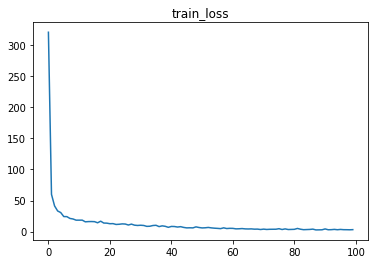

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history["loss"])
plt.title("train_loss")

Text(0.5, 1.0, 'validation_loss')

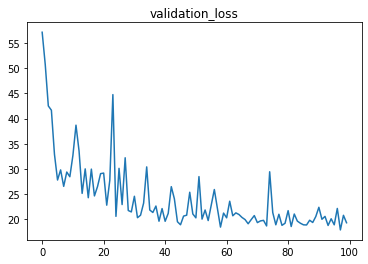

In [ ]:
plt.plot(hist.history["val_loss"])
plt.title("validation_loss")

In [ ]:
model.save("pt_model_cnn.h5")

### training with MLP model

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import tensorflow as tf
import pickle

outputs = 1
use_cnn= False

# from get_image_data import *

trX,trY = get_training_data(use_cnn)
teX,teY = get_test_data(use_cnn)

seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

if use_cnn:
    model = Sequential()
    model.add(Conv2D(4, (2, 2), padding='same', activation='relu', input_shape=(16, 16, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(8, (2, 2), padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))

else:
    model = Sequential()
    model.add(Dense(512, input_dim=np.shape(trX)[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

hist = model.fit(trX, trY, epochs=100, batch_size=10,
                 validation_data=(teX, teY))

Y_prediction = model.predict(teX).flatten()

with open("predict.txt", 'w') as file:
    for i in range(1000):
        label = teY[i]
        pred = Y_prediction[i]
        print("label:{:.3f}, pred:{:.3f}".format(label, pred))
        file.write("label:{:.3f}, pred:{:.3f}\n".format(label, pred))

def get_direction(img):
    # img = np.array([np.reshape(img,img.shape**2)])
    ret =  model.predict(np.array([img]))
    return ret

# Predict direction with single image
dir=get_direction(teX[10])
print(dir[0][0])

Epoch 1/100
280/280 [==============================] - 1s 2ms/step - loss: 565.4878 - val_loss: 134.0798
Epoch 2/100
280/280 [==============================] - 1s 2ms/step - loss: 90.6705 - val_loss: 101.3408
Epoch 3/100
280/280 [==============================] - 1s 2ms/step - loss: 62.0444 - val_loss: 60.1385
Epoch 4/100
280/280 [==============================] - 1s 2ms/step - loss: 43.0788 - val_loss: 61.5040
Epoch 5/100
280/280 [==============================] - 1s 2ms/step - loss: 35.8075 - val_loss: 55.2620
Epoch 6/100
280/280 [==============================] - 1s 2ms/step - loss: 36.7370 - val_loss: 61.8404
Epoch 7/100
280/280 [==============================] - 1s 2ms/step - loss: 29.3565 - val_loss: 82.7382
Epoch 8/100
280/280 [==============================] - 1s 2ms/step - loss: 24.8896 - val_loss: 46.6412
Epoch 9/100
280/280 [==============================] - 1s 2ms/step - loss: 25.6281 - val_loss: 47.8894
Epoch 10/100
280/280 [==============================] - 1s 2ms/step - 

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 164,481
Trainable params: 164,481
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'train_loss')

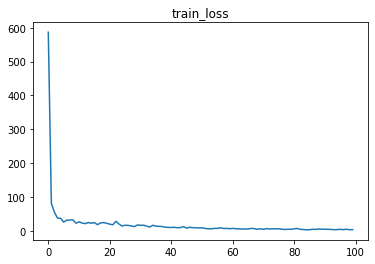

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history["loss"])
plt.title("train_loss")

Text(0.5, 1.0, 'validation_loss')

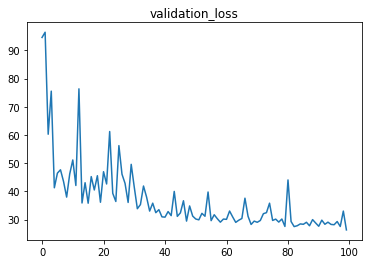

In [ ]:
plt.plot(hist.history["val_loss"])
plt.title("validation_loss")

In [ ]:
model.save("pt_model_mlp.h5")

### print image

In [ ]:
def print_image(dataset, use_cnn, idx):
    print("image : ")
    for i in range(dataset[idx][2].shape[0]):
        for j in range(dataset[idx][2].shape[0]):
            print("{:3}".format(dataset[idx][2][i, j]), end=' ')
        print("\n")

    print("label : ", (dataset[idx][0] - 1) * (-90))
    if use_cnn: print("predict : ", model.predict(np.array([dataset[idx][2][..., np.newaxis].astype(np.int16)]))[0][0])
    else: print("predict : ", model.predict(np.array([np.reshape(dataset[idx][2],dataset[idx][2].shape[0]**2)]))[0][0])

In [ ]:
dataset = test
use_cnn = True
idx = 425

print_image(dataset, use_cnn, idx)

image : 
  0   0   0   0   0   0   0   0   0   0 255 255   0   0   0   0 

  0   0   0   0   0   0   0   0   0   0 255 255   0   0   0   0 

  0   0   0   0   0   0   0   0   0   0 255 255   0   0   0   0 

  0   0   0   0   0   0   0   0   0   0 255 255   0   0   0   0 

  0   0   0   0   0   0   0   0   0   0 255 255   0   0   0   0 

  0   0   0   0   0   0   0   0   0   0 255 255   0   0   0   0 

  0   0   0   0   0   0   0   0   0 255 255 255   0   0   0   0 

  0   0   0   0   0   0   0   0   0 255 255 255   0   0   0   0 

  0   0   0   0   0   0   0   0   0 255 255 255   0   0   0   0 

  0   0   0   0   0   0   0   0   0 255 255 255   0   0   0   0 

  0   0   0   0   0   0   0   0   0 255 255   0   0   0   0   0 

  0   0   0   0   0   0   0   0   0 255 255   0   0   0   0   0 

  0   0   0   0   0   0   0   0   0 255 255   0   0   0   0   0 

  0   0   0   0   0   0   0   0   0 255 255   0   0   0   0   0 

  0   0   0   0   0   0   0   0   0 255 255   0   0   0   0   0 

 

## training with image 32*32

In [70]:
cd /content/drive/My Drive/Colab Notebooks/embedded_system_self_driving/AI_RC_Car_open and close

/content/drive/My Drive/Colab Notebooks/embedded_system_self_driving/AI_RC_Car_open and close


In [77]:
ls

32_trainingdata.p        new_trainingdata.p   self_driving.py
get_image_data.py        predict.txt          tf_learn.py
model.tflite             pt_model_cnn.h5      TF_test/
new_32_trainingdata_1.p  pt_model.h5          trainingdata.p
new_32_trainingdata_2.p  pt_model_mlp.h5
new_32_trainingdata_3.p  rc_car_interface.py


In [163]:
import pickle
import math
import numpy as np
from sklearn.model_selection import train_test_split

data = []
for i in range(1, 4):
    objects = []
        
    with  open(f"new_32_trainingdata_{i}.p", "rb") as file:
        while True:
            try:
                objects.append(pickle.load(file))
            except (pickle.UnpicklingError, EOFError) as e:
                break

        for i in range(len(objects)):
            data.extend(objects[i])

## except degree of 180
data_except = []
for i in range(len(data)):
    if data[i][0] == -1: pass
    else: data_except.append(data[i])

print(len(data), len(data_except))

training, test = train_test_split(data_except, test_size=0.33, random_state=42)

def get_training_data(use_cnn=True):
    if use_cnn:
        trX = np.array([a[2][..., np.newaxis].astype(np.int16) for a in training])
        trY = np.array([(a[0] - 1) *(-90) for a in training])
    else:
        trX = np.array([np.reshape(a[2],a[2].shape[0]**2) for a in training]) 
        trY = np.array([(a[0] - 1) *(-90) for a in training])
    return trX, trY


def get_test_data(use_cnn=True):
    if use_cnn:
        teX = np.array([a[2][..., np.newaxis].astype(np.int16) for a in test])
        teY = np.array([(a[0] - 1) *(-90) for a in test])
    else:
        teX = np.array([np.reshape(a[2],a[2].shape[0]**2) for a in test]) 
        teY = np.array([(a[0] - 1) *(-90) for a in test])
    return teX, teY


trX,trY = get_training_data(use_cnn=True)
teX,teY = get_test_data(use_cnn=True)

5500 5416


In [198]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, ReLU
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import tensorflow as tf
import pickle

outputs = 1
use_cnn= True

# from get_image_data import *

trX,trY = get_training_data(use_cnn)
teX,teY = get_test_data(use_cnn)

seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

if use_cnn:
    model = Sequential()
    model.add(Conv2D(8, (2, 2), strides=(2, 2), padding='same', activation='relu', input_shape=(32, 32, 1)))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    
    model.add(Conv2D(16, (2, 2), strides=(2, 2), padding='same', activation='relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (2, 2), padding='same', activation='relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())

    model.add(Dense(1))


model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

hist = model.fit(trX, trY, epochs=150, batch_size=100,
                 validation_data=(teX, teY))

Y_prediction = model.predict(teX).flatten()

with open("predict.txt", 'w') as file:
    for i in range(Y_prediction.shape[0]):
        label = teY[i]
        pred = Y_prediction[i]
        print("label:{:.3f}, pred:{:.3f}".format(label, pred))
        file.write("label:{:.3f}, pred:{:.3f}\n".format(label, pred))

Epoch 1/150
37/37 [==============================] - 0s 8ms/step - loss: 8326.3652 - val_loss: 7880.0542
Epoch 2/150
37/37 [==============================] - 0s 4ms/step - loss: 8038.8276 - val_loss: 7745.9756
Epoch 3/150
37/37 [==============================] - 0s 5ms/step - loss: 7788.9263 - val_loss: 7658.7769
Epoch 4/150
37/37 [==============================] - 0s 5ms/step - loss: 7508.7891 - val_loss: 7320.5342
Epoch 5/150
37/37 [==============================] - 0s 5ms/step - loss: 7198.3486 - val_loss: 7100.0659
Epoch 6/150
37/37 [==============================] - 0s 4ms/step - loss: 6855.0537 - val_loss: 6869.0239
Epoch 7/150
37/37 [==============================] - 0s 5ms/step - loss: 6481.0303 - val_loss: 6539.1333
Epoch 8/150
37/37 [==============================] - 0s 5ms/step - loss: 6067.7720 - val_loss: 5986.1260
Epoch 9/150
37/37 [==============================] - 0s 4ms/step - loss: 5633.9966 - val_loss: 5579.3472
Epoch 10/150
37/37 [==============================] - 0

In [195]:
model.summary()

Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_233 (Conv2D)          (None, 16, 16, 8)         40        
_________________________________________________________________
dropout_337 (Dropout)        (None, 16, 16, 8)         0         
_________________________________________________________________
batch_normalization_350 (Bat (None, 16, 16, 8)         32        
_________________________________________________________________
conv2d_234 (Conv2D)          (None, 8, 8, 16)          528       
_________________________________________________________________
dropout_338 (Dropout)        (None, 8, 8, 16)          0         
_________________________________________________________________
batch_normalization_351 (Bat (None, 8, 8, 16)          64        
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 4, 16)        

In [ ]:
def print_image(dataset, use_cnn, idx):
    print("image : ")
    for i in range(dataset[idx][2].shape[0]):
        for j in range(dataset[idx][2].shape[0]):
            print("{:3}".format(dataset[idx][2][i, j]), end=' ')
        print("\n")

    print("label : ", (dataset[idx][0] - 1) * (-90))
    if use_cnn: print("predict : ", model.predict(np.array([dataset[idx][2][..., np.newaxis].astype(np.int16)]))[0][0])
    else: print("predict : ", model.predict(np.array([np.reshape(dataset[idx][2],dataset[idx][2].shape[0]**2)]))[0][0])


count = 0
for i in range(Y_prediction.shape[0]):
    label = teY[i]
    pred = Y_prediction[i]
    if abs(label - pred) > 15:
        print_image(test, True, i); print("\n")
        count += 1
        
print(count)

In [191]:
model.save("new_pt_model_cnn.h5")

## TFLite

In [182]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
    f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpz305d5np/assets


In [189]:
## load .tflite model
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

## get test image and inference
test_image = np.array([dataset[idx][2][..., np.newaxis].astype(np.float32)])
print_image(dataset, use_cnn, idx)

interpreter.set_tensor(input_details[0]['index'], test_image)
interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])[0][0]
print("tflite inference :", output_data)

image : 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

 51   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

250 128   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

255 255 204  38   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

255 255 255 242 105   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

255 255 255 255 255 186  26   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

255 255 255 255 255 255 237  89   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

255 255 255 255 255 255 255 255 166  20   0   0   0   0   0   0   0   0   0   0  